In [107]:

import os
import sys
import pandas as pd
import numpy as np
import warnings 
import scipy.stats as scs
import matplotlib.pyplot as plt

In [108]:
# Suppressing warning messages

warnings.filterwarnings('ignore')

In [109]:
# setting path to folders

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
scripts_dir = parent_dir+"/scripts"
data_dir = parent_dir+"/data"

sys.path.insert(1, scripts_dir)

In [110]:
# loading script

from data_summarizing_functions import DataSummarizer
from dashboard_viz import VizManager
from DistributionPlots import DistributionPlots as DisP
from pipeline import pipeline, clean__and_save_data, aggregate_exprement_group

sumar = DataSummarizer()
viz = VizManager()
dis_p = DisP()

In [118]:
aggr_df = pipeline(clean__and_save_data, aggregate_exprement_group)
print(aggr_df)
# pipeline(clean__and_save_data, aggregate_exprement_group)


  experiment  count  percentage
0    control    586   47.144006
1    exposed    657   52.855994
None


In [112]:
# loading data

clean_df = pd.read_csv(data_dir+"/SmartAd_clean_data.csv")

## Univariate Analysis

In [113]:
# Displaying unique values for each categorical variables.

sumar_df = sumar.summ_columns(clean_df)
sumar_df

,variables,missing_count,missing_percent_(%),data_type,unique_values
0,auction_id,0,0.0,object,1243
1,experiment,0,0.0,object,2
2,date,0,0.0,object,8
3,hour,0,0.0,int64,24
4,device_make,0,0.0,object,115
5,platform_os,0,0.0,int64,2
6,browser,0,0.0,object,8
7,yes,0,0.0,int64,2
8,no,0,0.0,int64,2


In [114]:
# exploring the identity of experiment groups.
aggr_df

TypeError: 'NoneType' object is not subscriptable

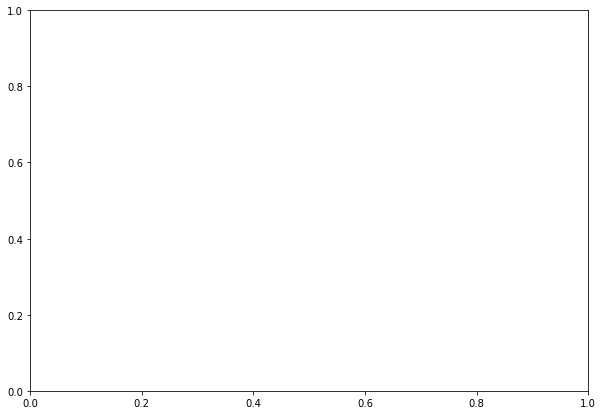

In [115]:
viz.plot_pie(aggr_df, ["experiment", "count"], "Experiment groups")

**Observation**
- experiment groups are almost equal in proportion
- the exposed group is slightly larger in number

In [ ]:
# displaying top 10 devices used by users.

temp_df = sumar.find_agg(clean_df, ["device_make"], ["auction_id"], ["count"],["user_count"])
sumar.show_N_per_col(temp_df, "device_make", ["user_count"], 10)


Top 10 customers based on user_count

            device_make  user_count
13   Generic Smartphone         719
68     Samsung SM-G960F          45
66     Samsung SM-G950F          35
72     Samsung SM-G973F          22
43     Samsung SM-A202F          18
114              iPhone          18
64     Samsung SM-G930F          16
73     Samsung SM-G975F          15
47    Samsung SM-A405FN          14
42    Samsung SM-A105FN          13


**Observation**
- following generic device types, samsung models are the most dominant device type

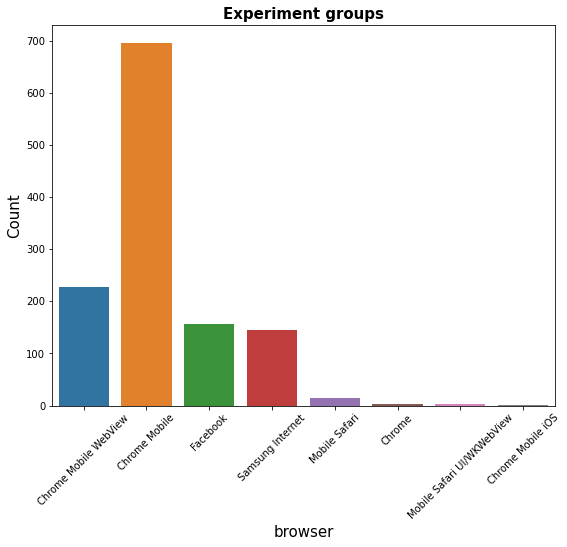

In [ ]:
viz.plot_bar(clean_df,"browser", "None", "Experiment groups")

**Observation**
- Chrome browser is the most used type of browser.

Text(0.5, 1.0, 'Distribution of hour ')

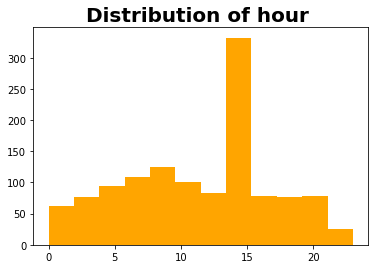

In [ ]:
# plotting distribution of houre variable.


plt.hist(clean_df['hour'],bins=12, color='orange')
plt.title(f'Distribution of hour ', size=20, fontweight='bold')

## Bivariate Analysis

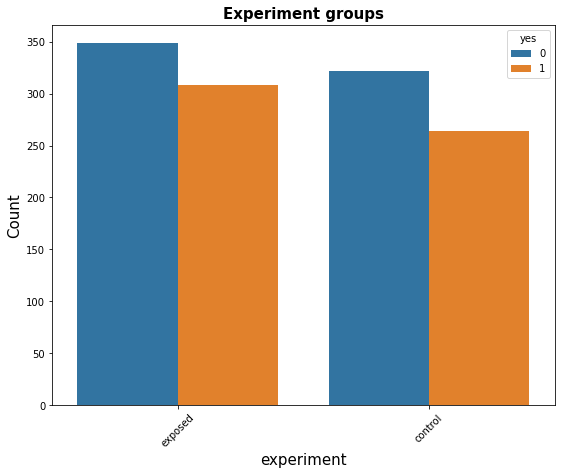

In [ ]:
viz.plot_bar(clean_df,"experiment", "yes", "Experiment groups")

In [ ]:
# the aggregation of the data by experiment

ab_summary = clean_df.pivot_table(values = "yes", index = "experiment", aggfunc=np.sum)
ab_summary

,yes
experiment,
control,264
exposed,308


In [ ]:
# calculating baseline conversion rate
ab_summary['total'] = clean_df.pivot_table(values="yes", index="experiment", aggfunc=lambda x: len(x))
ab_summary['rate'] = clean_df.pivot_table(values="yes", index="experiment")
ab_summary

,yes,total,rate
experiment,,,
control,264,586,0.450512
exposed,308,657,0.468798


In [ ]:
# bcr extraction

bcr = ab_summary.loc["control", "rate"]
d_hat = 0.015 # setting the desired conversion rate of 1.5%
cr = ab_summary.loc["exposed", "rate"]
cr_dif = np.round(cr - bcr, 4)
print("there is a conversion rate difference of : ",cr_dif)

there is a conversion rate difference of :  0.0183


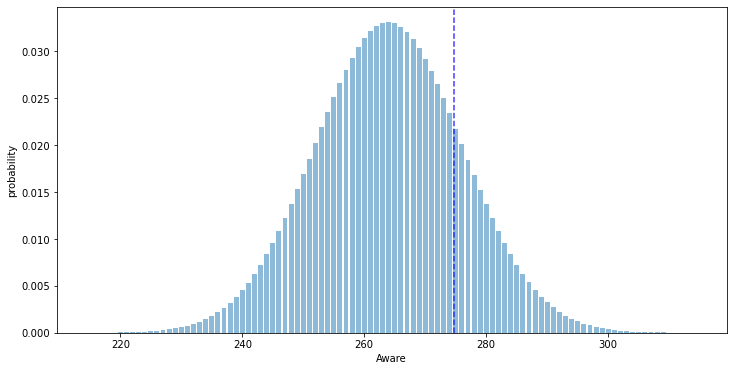

In [ ]:
# drawing the distribution of the control group
c_aware = ab_summary.loc["control", "yes"]
c_total = ab_summary.loc["control", "total"]
c_cr = ab_summary.loc["control", "rate"]
e_cr = ab_summary.loc["exposed", "rate"]
dis_p.cont_distribution(c_aware, c_total, c_cr, e_cr)

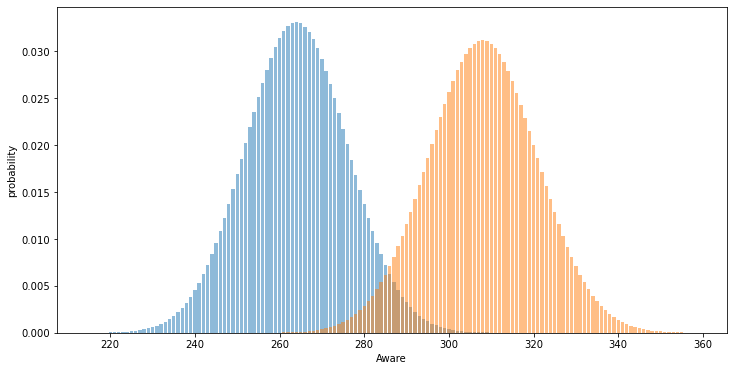

In [ ]:
e_aware = ab_summary.loc["exposed", "yes"]
e_total = ab_summary.loc["exposed", "total"]
dis_p.cont_exp_distribution(c_aware, e_aware, c_total, e_total, c_cr, e_cr)

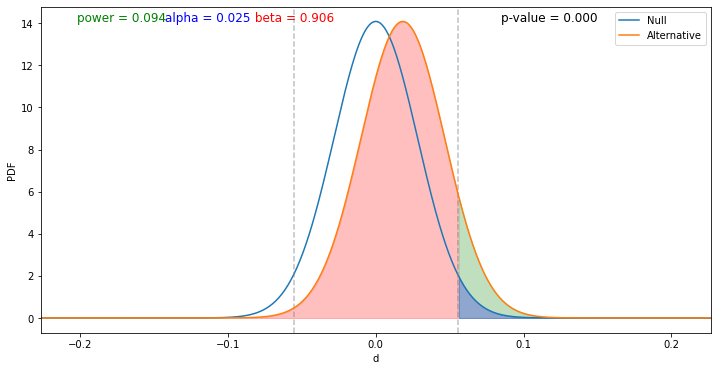

In [ ]:
# showing the normal distribution of the the null hypothesis and the alternative hypothesis.

dis_p.null_alt_distribution(c_total, e_total, c_cr, e_cr)

In [ ]:
# calculate the sample size needed for the specified power and confidence level


def min_sample_size(bcr, mde, power=0.8, sig_level=0.05):
    standard_norm = scs.norm(0, 1)
    beta = standard_norm.ppf(power)
    alpha = standard_norm.ppf(1-sig_level/2)
    pooled_prob = (bcr + bcr+mde) / 2
    min_N = (2 * pooled_prob * (1 - pooled_prob) * (beta + alpha)**2/ mde**2)
    return min_N

In [ ]:
power = 0.8
sig_level = 0.05
sample_80 = round(min_sample_size(c_cr, cr_dif, power,  sig_level))
print(f'Minimum sample size for 80% statistical power is : {sample_80} ')

Minimum sample size for 80% statistical power is : 11642 
